In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from matplotlib import pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(0.2860, 0.3530)
])

In [4]:
root = '/content'
train_set = datasets.FashionMNIST(
    root,
    train=True,
    transform=transform,
    download=True
)
test_set = datasets.FashionMNIST(
    root,
    train=False,
    transform=transform,
    download=True
)

100%|██████████| 26421880/26421880 [00:02<00:00, 10176467.66it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 170218.37it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3113759.36it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22680963.23it/s]


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [5]:
batch_size = 128

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

In [32]:
class NiN(nn.Module):
    def __init__(self, num_classes=10):
        super(NiN, self).__init__()
        self.net = nn.Sequential(
            self.nin_block(96, 11, 4, 0),
            nn.MaxPool2d(3, stride=2),
            self.nin_block(256, 5, 1, 2),
            nn.MaxPool2d(3, stride=2),
            self.nin_block(384, 3, 1, 1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            self.nin_block(num_classes, 3, 1, 1),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

    def nin_block(self, out_channels, kernel_size, strides, padding):
        return nn.Sequential(
            nn.LazyConv2d(out_channels, kernel_size, stride=strides, padding=padding), nn.ReLU(),
            nn.LazyConv2d(out_channels, 1), nn.ReLU(),
            nn.LazyConv2d(out_channels, 1), nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

In [33]:
model_for_summary = NiN().to(device)
summary(model_for_summary, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          11,712
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]           9,312
              ReLU-4           [-1, 96, 54, 54]               0
            Conv2d-5           [-1, 96, 54, 54]           9,312
              ReLU-6           [-1, 96, 54, 54]               0
         MaxPool2d-7           [-1, 96, 26, 26]               0
            Conv2d-8          [-1, 256, 26, 26]         614,656
              ReLU-9          [-1, 256, 26, 26]               0
           Conv2d-10          [-1, 256, 26, 26]          65,792
             ReLU-11          [-1, 256, 26, 26]               0
           Conv2d-12          [-1, 256, 26, 26]          65,792
             ReLU-13          [-1, 256, 26, 26]               0
        MaxPool2d-14          [-1, 256,

In [34]:
input = torch.randn(1, 1, 224, 224).float().to(device)
out = model_for_summary(input)
print(out)

tensor([[0.0000, 0.0000, 0.2159, 0.0000, 0.2449, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], device='cuda:0', grad_fn=<ViewBackward0>)


In [35]:
def train_run_epoch(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    return avg_loss

In [10]:
def test_run_epoch(model, device, test_loader):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            pred = output.argmax(1)
            correct += pred.eq(target).sum().item()

            total_loss += loss.item()

        accuracy = correct / len(test_set)
        avg_loss = total_loss / len(test_loader)

    return accuracy, avg_loss

In [11]:
def train(model, device, train_loder, test_loader, optimizer, criterion, num_epochs):
    train_avg_losses = []
    test_avg_losses = []
    accuracies = []

    for epoch in range(1, num_epochs+1):
        print(f"Epoch [{epoch}/{num_epochs}]")

        train_avg_loss = train_run_epoch(model, device, train_loader, optimizer, criterion)
        train_avg_losses.append(train_avg_loss)
        print(f"Average Train Loss = {train_avg_loss:.20f}")

        accuracy, test_avg_loss = test_run_epoch(model, device, test_loader)
        test_avg_losses.append(test_avg_loss)
        accuracies.append(accuracy)
        print(f"Average Test Loss = {test_avg_loss:.20f}")
        print(f"Test Accuracy = {accuracy:.2f}")
        print()

    return train_avg_losses, test_avg_losses, accuracies

In [36]:
num_epochs = 10
learning_rate = 0.001

nin = NiN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nin.parameters(), lr=learning_rate)

In [37]:
train_losses, test_losses, accuracies = train(nin, device, train_loader, test_loader, optimizer, criterion, num_epochs)

Epoch [1/10]
Average Train Loss = 1.31236871829165080428
Average Test Loss = 0.92141923119750201998
Test Accuracy = 0.71

Epoch [2/10]
Average Train Loss = 0.76198953498146937413
Average Test Loss = 0.69784029261975344394
Test Accuracy = 0.76

Epoch [3/10]
Average Train Loss = 0.67308913142696369381
Average Test Loss = 0.65059175710134864445
Test Accuracy = 0.78

Epoch [4/10]
Average Train Loss = 0.62499160159117128632
Average Test Loss = 0.61595007739489593401
Test Accuracy = 0.79

Epoch [5/10]
Average Train Loss = 0.59938088841021441855
Average Test Loss = 0.58895524053633963035
Test Accuracy = 0.80

Epoch [6/10]
Average Train Loss = 0.58113245364191179476
Average Test Loss = 0.58509969371783587810
Test Accuracy = 0.79

Epoch [7/10]
Average Train Loss = 0.54435724655448247677
Average Test Loss = 0.56900205566913264477
Test Accuracy = 0.80

Epoch [8/10]
Average Train Loss = 0.51614079470319285114
Average Test Loss = 0.55538120828097381487
Test Accuracy = 0.80

Epoch [9/10]
Average Tra

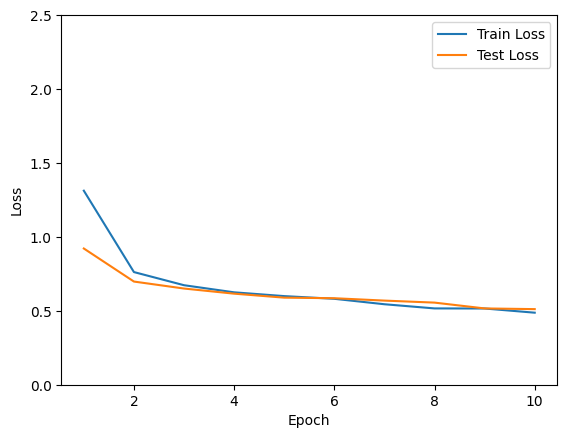

In [38]:
X = range(1, num_epochs+1)
plt.plot(X, train_losses, label="Train Loss")
plt.plot(X, test_losses, label="Test Loss")
plt.xticks(range(2, num_epochs+1, 2))
plt.legend()
plt.ylim(0, 2.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

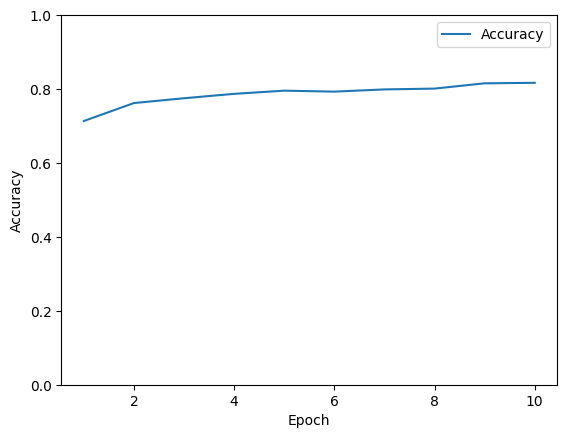

In [39]:
plt.plot(X, accuracies, label="Accuracy")
plt.xticks(range(2, num_epochs+1, 2))
plt.legend()
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()